# Lab: CNN Visualization
*Mark Brubaker & Eli Mann*

 ## In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet).
*These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) https://keras.io/api/applications/Links to an external site.*
*It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.*
*Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.*

 ## Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit.
*This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are a few convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/Links to an external site.*
* *Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class:https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynbLinks to an external site.*
* *Also send images of varying class (i.e. from ImageNet) through the network and track which classes of images most excite your chosen filter.*
* *Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network?*
* *If using code from another source, you must heavily document the code so that I can grade your understanding of the code used.*

## Analyze each channel of the multi-channel filter to this feature that might form a circuit.
*That is, visualize the convolutional filter (one channel) between the input activations and the current activation to understand which inputs make up a circuit. One method of doing this is given below:*
* *Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5.*
* *Keep the top six sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top six filters.*
* *For these six strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?*

## For each of the six chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by
*That is, what image maximally excites each of these filters. This is a similar analysis to the first step, but now isolating the filters directly before your chosen filter.*
* *Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here: https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.htmlLinks to an external site.*
* *Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/Links to an external site. (such as determining if this is polysemantic, pose-invariant, etc.)*
* *Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why?*

# Visualizing an Convolutional Neural Network using Curcuits

For this analysis we will be visualizing the VGG19 model. VGG19 is a convolutional neural network that is trained on the ImageNet dataset. We chose this model as it has been trained on a large dataset, and does not have residual connections. This makes it easier to visualize the circuits. We will be using the OpenAI microscope to select a filter to analyze. 

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import vgg19 pretrained model from keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras import models
from keras import backend as K

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# block3_conv2 filter 16 is good for pier.jpg
# block5_conv2 filter 16 is good for dog.jpg
layer_name = 'block5_conv2'
filter_num = 16

# load the model
model = VGG19(weights='imagenet', include_top=True)

# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer(layer_name).output)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 0s 15ms/step


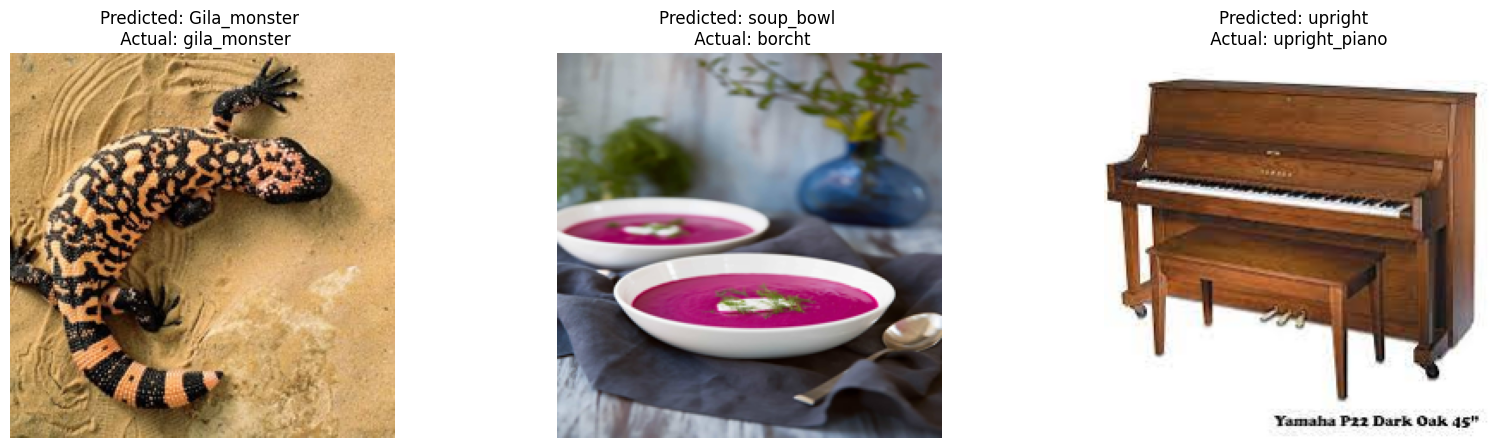

In [4]:
path = 'images/'

# Set up the plot grid
fig, axs = plt.subplots(1, len(os.listdir(path)), figsize=(20, 5))

# Iterate through the images and plot them
for i, filename in enumerate(os.listdir(path)):
    img = Image.open(os.path.join(path, filename)).resize((224, 224))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    axs[i].imshow(img)
    axs[i].set_title(f'Predicted: {decode_predictions(preds, top=1)[0][0][1]} \n Actual: {filename.split(".")[0]}')
    axs[i].axis('off')

plt.show()


VGG19 has 19 layers, and we will be analyzing a multi-channel filter from the the 12th called 'block4_conv4' layer since it is a mid-level layer - it has several convolutional layers before and after it.

In [5]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)

        
    return new_img.astype('uint8')


def generate_pattern(layer_name, filter_index, size=224):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            loss = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(loss, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

# prepare the images for VGG19
def prepare_image_for_vgg(img):
    x = np.array(img)
    if x.ndim == 2:  # grayscale image
        x = np.stack([x, x, x], axis=-1)
    elif x.shape[2] == 4:  # RGBA image
        x = Image.fromarray(x).convert('RGB')
        x = np.array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def plot_heatmap_on_image(image, heatmap, ax, cmap='viridis', alpha=0.5):
    """
    Plots a heatmap on an image.
    :param image: The PIL image object
    :param heatmap: The 2D numpy array representing the heatmap
    :param ax: The matplotlib axis to plot on
    :param cmap: The colormap to use for the heatmap
    :param alpha: The transparency level of the heatmap
    """
    ax.imshow(image)
    im = ax.imshow(heatmap, cmap=cmap, alpha=alpha, extent=(0, 224, 224, 0))
    plt.colorbar(im, ax=ax, shrink=0.7)

In [6]:
# write a function to vizualiize the filters
def visualize_filters(layer_name, size=224):
    # Get the number of filters in the layer
    n_filters = model.get_layer(layer_name).output_shape[-1]
    # We will tile our images in this matrix
    results = np.zeros((size * n_filters, size * 3, 3))
    # Iterate over all the filters
    for i in range(n_filters):
        # Generate the pattern for filter i
        filter_img = generate_pattern(layer_name, i, size=size)
        # Put the result in the square (i,j)
        results[i * size : (i + 1) * size, :size, :] = filter_img
        # Display the results
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

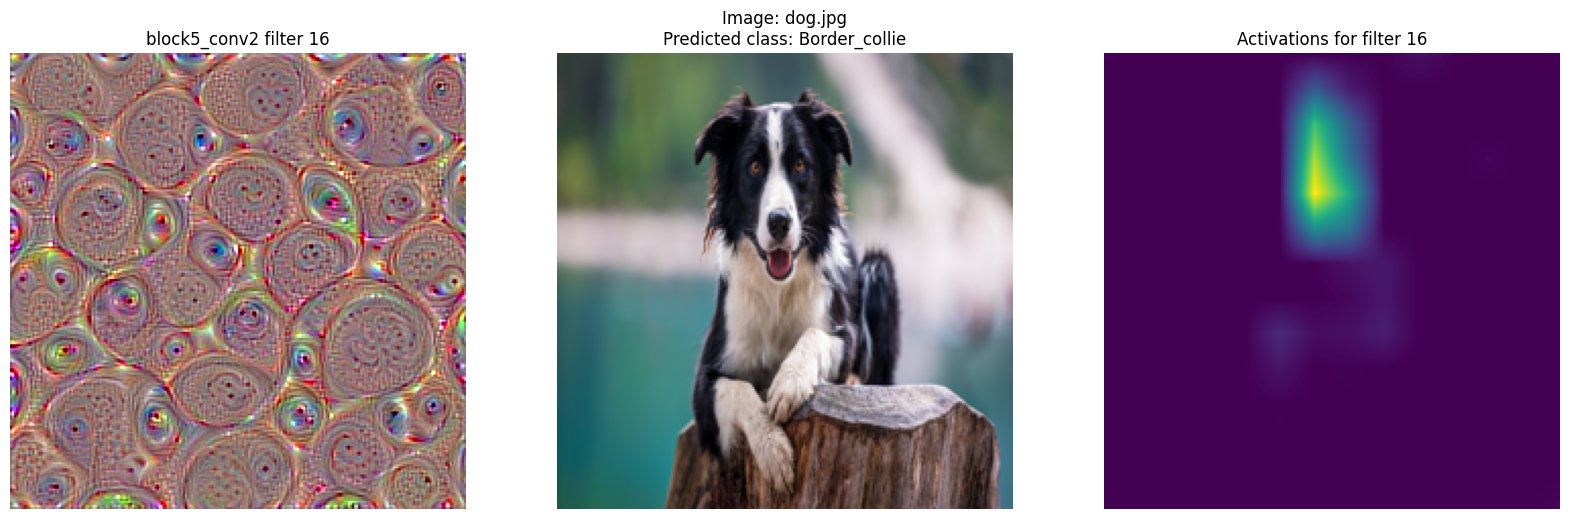

In [7]:
def plot_filter_image_and_activations(layer_name, filter_num, img_path):
    img = Image.open(img_path).resize((224, 224))
    img_array = prepare_image_for_vgg(img)
    preds = model.predict(img_array, verbose=0)
    label = decode_predictions(preds, top=1)[0][0][1]

    activation = intermediate_layer_model.predict(img_array, verbose=0)
    heatmap = activation[0, :, :, filter_num]
    heatmap = sp.ndimage.zoom(heatmap, (224/heatmap.shape[0], 224/heatmap.shape[1]), order=1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display the filter
    axes[0].imshow(generate_pattern(layer_name, filter_num))
    axes[0].set_title(f'{layer_name} filter {filter_num}')
    axes[0].axis('off')

    # Display the image
    axes[1].imshow(img)
    axes[1].set_title(f'Image: {os.path.basename(img_path)}\nPredicted class: {label}')
    axes[1].axis('off')

    # Display the activations as their own image
    axes[2].imshow(heatmap)
    axes[2].set_title(f'Activations for filter {filter_num}')
    axes[2].axis('off')

    plt.show()

# img_path = 'pier.jpg'
img_path = 'dog.jpg'
plot_filter_image_and_activations(layer_name, filter_num, img_path)


In [8]:
# load the ImageNet sample images from /ImageNet_Samples
# each image is class_name.JPEG

# load the images
path = 'ImageNet_Samples/'
images = []

for filename in os.listdir(path):
    img = Image.open(os.path.join(path, filename)).resize((224, 224))
    image_arr = prepare_image_for_vgg(img)
    if image_arr.shape != (1, 224, 224, 3):
        print(f"Skipping {filename} due to incorrect shape: {image_arr.shape}")
        continue
    images.append(image_arr)

# predict for each image and record the activations of block4_conv4 filter {filter_num}
# get the 5 images that excite that filter the most

activations = []
for img_arr in images:
    activation = intermediate_layer_model.predict(img_arr, verbose=0)
    activations.append(activation)

This runs a dataset that contains one example of each class in the ImageNet dataset. This will help us get a diverse picture of what the filter is looking for and what type of images it is most excited by.

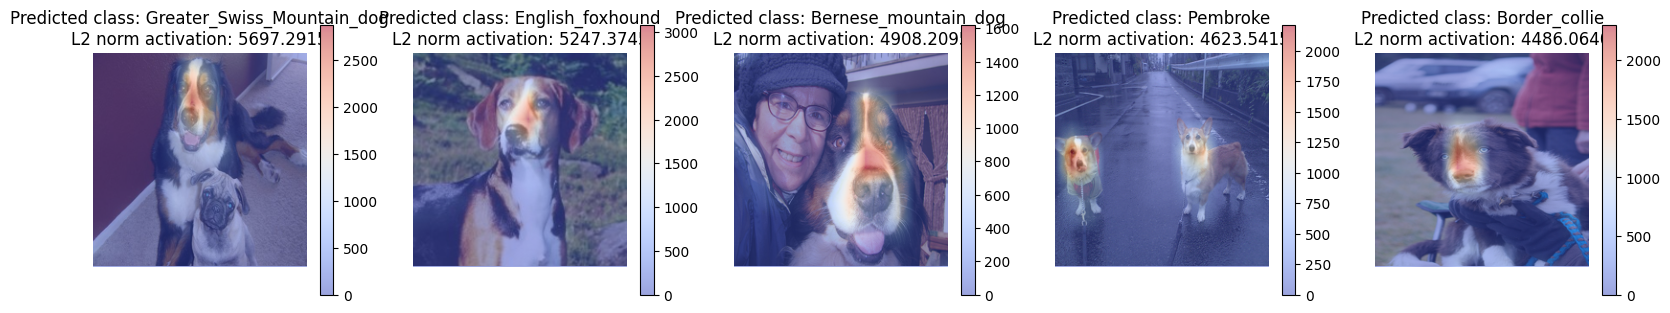

In [9]:
def l2_norm(activation):
    """
    Computes the L2 norm of an activation.
    :param activation: The 3D numpy array representing the activation
    :return: The L2 norm value
    """
    return np.sqrt(np.sum(np.square(activation)))

# Find the L2 norm of the activations for the specified filter
l2_norm_activations = [l2_norm(activation[:, :, :, filter_num]) for activation in activations]

# Get the indices of the top 5 images that excite the filter the most
top_5_indices = np.argsort(l2_norm_activations)[-5:][::-1]

# Plot the top 5 images with heatmaps using the L2 norm activation
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, index in enumerate(top_5_indices):
    img = Image.open(os.path.join(path, os.listdir(path)[index])).resize((224, 224))
    img_array = images[index]
    preds = model.predict(img_array, verbose=0)
    label = decode_predictions(preds, top=1)[0][0][1]
    activation = activations[index]
    heatmap = activation[0, :, :, filter_num]
    heatmap = sp.ndimage.zoom(heatmap, (224/heatmap.shape[0], 224/heatmap.shape[1]), order=1)

    plot_heatmap_on_image(img, heatmap, axes[i], cmap='coolwarm', alpha=0.5)
    axes[i].set_title(f'Predicted class: {label}\nL2 norm activation: {l2_norm_activations[index]:.4f}')
    axes[i].axis('off')

plt.show()


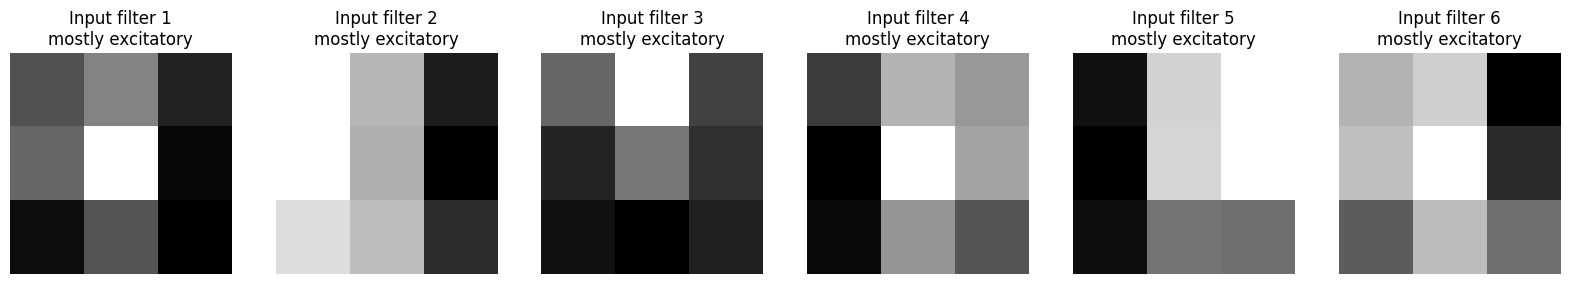

In [10]:
def get_filter_coefficients(layer_name, filter_num):
    # Get the layer object
    layer = model.get_layer(layer_name)

    # Get the layer's weights
    weights = layer.get_weights()[0]

    # Get the filter coefficients for the specified filter number
    filter_coefficients = weights[:, :, :, filter_num]

    return filter_coefficients

def get_top_six_strongest_filters(layer_name, filter_num):
    filter_coefficients = get_filter_coefficients(layer_name, filter_num)
    
    # Calculate the L2 norm for each input filter
    l2_norms = [l2_norm(filter_coefficients[:, :, i]) for i in range(filter_coefficients.shape[2])]
    
    # Get the indices of the top six strongest input filters
    top_six_indices = np.argsort(l2_norms)[-6:][::-1]
    
    return filter_coefficients[:, :, top_six_indices], top_six_indices

def categorize_filter(filter_coefficients):
    if np.mean(filter_coefficients) > 0:
        return "mostly excitatory"
    else:
        return "mostly inhibitory"

# Example usage
# layer_name = 'block3_conv2'
# filter_num = 16

top_six_filters, top_six_filter_indices = get_top_six_strongest_filters(layer_name, filter_num)
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for i in range(6):
    filter_coefficients = top_six_filters[:, :, i]
    category = categorize_filter(filter_coefficients)
    
    # Normalize the filter coefficients for visualization
    normalized_filter = (filter_coefficients - filter_coefficients.min()) / (filter_coefficients.max() - filter_coefficients.min())
    
    axes[i].imshow(normalized_filter, cmap='gray')
    axes[i].set_title(f'Input filter {i + 1}\n{category}')
    axes[i].axis('off')

plt.show()

# Below is from ChatGPT

We are visualizing the top six strongest input filters for a given convolutional layer and filter number within a pre-trained VGG19 model. These input filters are the sets of weights that are applied to different input channels of the given layer.

A filter in a convolutional layer is a small matrix of weights that is applied to the input channels to detect specific features or patterns. Each filter within a convolutional layer has multiple input filters, one for each input channel. For example, in the case of an RGB image, there will be three input filters for each filter in the first convolutional layer, one for each of the red, green, and blue channels.

In our example, we first calculate the L2 norm for each input filter of the specified multi-channel filter in the given layer. The L2 norm is a measure of the "strength" of the input filter, which in this context represents the magnitude of the weights. Then, we select the top six strongest input filters based on their L2 norm values.

We then visualize these top six strongest input filters as grayscale images, where each pixel in the image represents a weight in the input filter matrix. The darker pixels represent smaller (more negative) weights, while the lighter pixels represent larger (more positive) weights.

Additionally, we categorize each of the top six input filters as "mostly inhibitory" or "mostly excitatory" based on their coefficients. An input filter is considered "mostly inhibitory" if it has mostly negative coefficients, which means it suppresses the input features, whereas an input filter is considered "mostly excitatory" if it has mostly positive coefficients, which means it enhances the input features. This categorization provides a high-level understanding of the effect of each input filter on the input channels.

In summary, the visualization shows the top six strongest input filters for a specified multi-channel filter in a given convolutional layer of the VGG19 model, along with their categorization based on the nature of their coefficients. This helps us understand which input filters have the strongest influence on the output of the specified multi-channel filter and their effect on the input features.

Top six strongest input filters for filter 16 in layer block5_conv1:
[ 54  25 148 143 195 124]


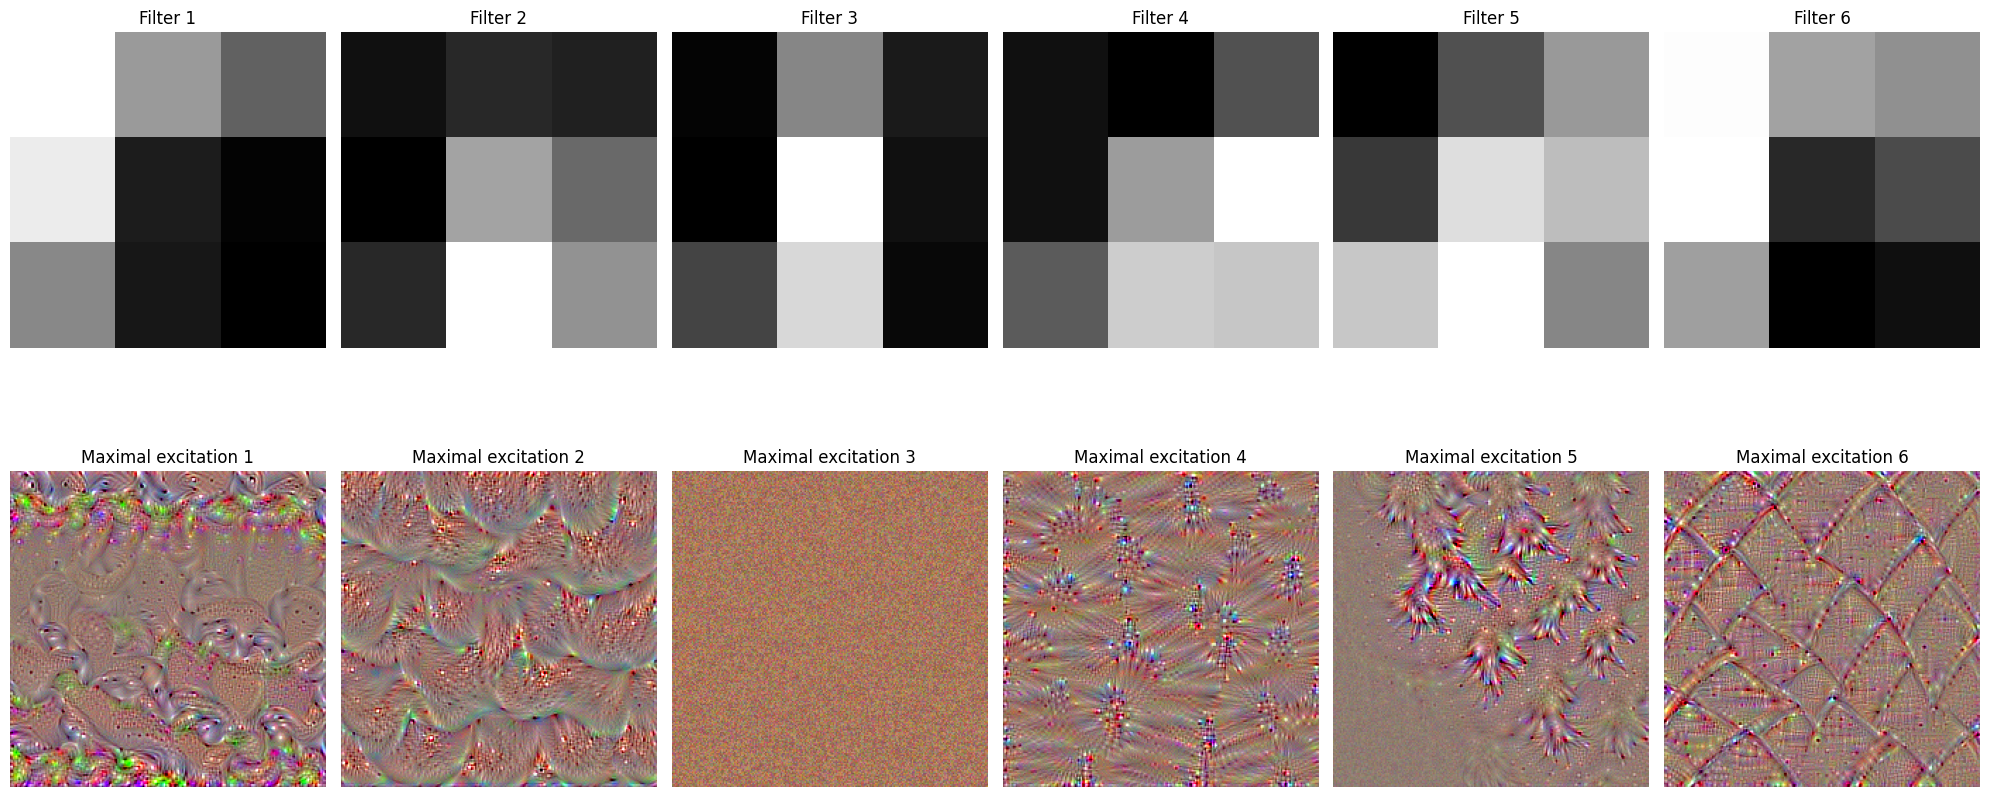

In [11]:
def generate_pattern_channel(layer_name, filter_index, channel, size=224):
    layer_output = model.get_layer(layer_name).output
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    I_start = tf.Variable(input_img_data, name='image_var', dtype='float64')
    I = preprocess_input(I_start)

    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            model_vals = new_model(I)
            loss = tf.reduce_mean(model_vals[:, :, :, channel])

        grad_fn = tape.gradient(loss, I)
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5)
        I += grad_fn * eta

    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')


layer_name = 'block5_conv1'
filter_num = 16

top_six_filters, top_six_filter_indices = get_top_six_strongest_filters(layer_name, filter_num)

# plot each filter next to the corresponding channel
fig, axes = plt.subplots(2, 6, figsize=(20, 10))

# print the indices of the top six strongest input filters
print(f'Top six strongest input filters for filter {filter_num} in layer {layer_name}:')
print(top_six_filter_indices)

for i, channel in enumerate(top_six_filter_indices):
    # Display the filter
    filter_coefficients = top_six_filters[:, :, i]
    normalized_filter = (filter_coefficients - filter_coefficients.min()) / (filter_coefficients.max() - filter_coefficients.min())
    axes[0, i].imshow(normalized_filter, cmap='gray')
    axes[0, i].set_title(f'Filter {i + 1}')
    axes[0, i].axis('off')
    
    # Display the pattern that maximally excites the filter
    img = generate_pattern_channel(layer_name, filter_num, channel)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Maximal excitation {i + 1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [12]:
import tqdm
from tqdm import tqdm

for layer_name in ['block3_conv1', 'block3_conv3']:
    break
    size = 224
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype('uint8')

    for i in tqdm(range(8)):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.title(layer_name)
    plt.show()